In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 1000)

In [45]:
seasons = [2015, 2016, 2017, 2018, 2019]

In [ ]:
coop_lst = []
url = 'https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_'
for season in seasons:
    print(f'Reading in Play-By-Play data for the {season} season')
    season_pbp = pd.read_csv(url + str(season) + '.csv')
    coop_pbp = season_pbp.loc[season_pbp.receiver_player_id == '00-0031544']
    coop_lst.append(coop_pbp)
    
coop_df = pd.concat(coop_lst).reset_index(drop=True)

Reading in Play-By-Play data for the 2015 season
Reading in Play-By-Play data for the 2016 season


In [17]:
coop_df['game_date'] = pd.to_datetime(coop_df['game_date'])
coop_df['month'] = coop_df.game_date.dt.month
coop_df['year'] = coop_df.game_date.dt.year

In [20]:
yards_per_game = coop_df.groupby(['game_id', 'year', 'month',
                                  'home_team', 'away_team'], as_index=False)['yards_gained'].sum()

In [22]:
team_yards_in_a_month = coop_df.groupby(['month', 'posteam'], as_index = False)['yards_gained'].sum() \
    .sort_values(['month', 'posteam'])

sns.barplot(x= 'month', y = 'yards_gained', data=team_yards_in_a_month, hue='posteam')

In [24]:
team_games_in_a_month = coop_df.groupby(['month', 'posteam'], as_index=False)['game_id'] \
    .agg({'games': pd.Series.nunique}) \
    .sort_values(['month', 'posteam'])

graph_df = team_yards_in_a_month.merge(team_games_in_a_month, on = ['month', 'posteam'])

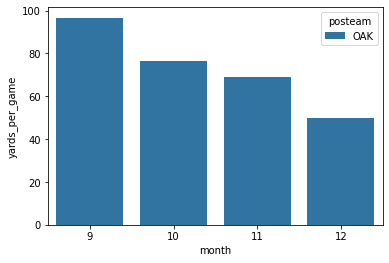

In [25]:
graph_df['yards_per_game'] = graph_df['yards_gained'] / graph_df['games']

sns.barplot(x='month', y='yards_per_game', hue='posteam', data=graph_df.loc[graph_df.month != 1])

In [ ]:
# team_yards_in_a_qtr = coop_df.groupby(['qtr', 'posteam', 'month'], as_index = False)['yards_gained'].sum() \
#     .sort_values(['qtr', 'posteam'])

# sns.barplot(x='qtr', y='yards_gained', data=team_yards_in_a_qtr.loc[team_yards_in_a_qtr.qtr != 5], #hue='posteam'
#            )

# g = sns.FacetGrid(team_yards_in_a_qtr, col="qtr", col_wrap=2, height=1.5)
# g = g.map(plt.hist, "month", "yards_gained", marker=".")

In [26]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [27]:
#seasons = ['2015','2016','2017','2018','2019',]
weeks = [str(w) for w in range(1, 18)]
url = 'http://www.nflweather.com/en/week/'

In [28]:
def request_data(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    return soup

def get_team_data(bs_data):
    teams = bs_data.find_all(class_="team-name text-center")

    away_teams = []
    home_teams = []

    for i, v in enumerate(teams):
        if i % 2 == 0:
            away_teams.append(teams[i].find('a').contents[0])
        else:
            home_teams.append(teams[i].find('a').contents[0])
            
    return away_teams, home_teams

def get_weather_data(bs_data):
    games = bs_data.find_all('tr')

    weather_lst = []
    for i, v in enumerate(games):
        #skip header
        if i > 0:
            game_details = games[i].find_all(class_='text-center')

            forecast = game_details[5].contents[0]

            weather_lst.append(' '.join(forecast.split()))
            
    return weather_lst

In [38]:
weather_lst = []

for season in seasons:
    print(f'Scraping Weather Data for the {season} Season')
    for week in weeks:
        request_url = f'{url}{season}/week-{week}'
        soup = request_data(request_url)
        
        away_teams, home_teams = get_team_data(soup)
        
        weather = get_weather_data(soup)
        
        weather_df = pd.DataFrame({'away_team': away_teams,
                                   'home_team': home_teams,
                                   'weather': weather,
                                  })
        
        weather_df['year'] = season
        weather_df['week'] = week
        
        weather_lst.append(weather_df)
        
full_weather_df = pd.concat(weather_lst).reset_index(drop=True)

Scraping Weather Data for the 2015 Season
Scraping Weather Data for the 2016 Season
Scraping Weather Data for the 2017 Season
Scraping Weather Data for the 2018 Season
Scraping Weather Data for the 2019 Season


In [40]:
cowboys_weather_df = full_weather_df.loc[(full_weather_df.away_team == 'Cowboys') |
                                         (full_weather_df.home_team == 'Cowboys')
                                        ]

In [41]:
yards_per_game.shape

(16, 6)

In [42]:
yards_per_game.head()

,game_id,year,month,home_team,away_team,yards_gained
0,2015091310,2015,9,OAK,CIN,47
1,2015092010,2015,9,OAK,BAL,109
2,2015092708,2015,9,CLE,OAK,134
3,2015100401,2015,10,CHI,OAK,49
4,2015101110,2015,10,OAK,DEN,47


In [43]:
yards_per_game.merge(cowboys_weather_df, on = ['home_team', 'away_team', 'year'])

,game_id,year,month,home_team,away_team,yards_gained,weather,week


In [31]:
cowboys_weather_df.head()

,away_tm,home_tm,weather,season,week
13,Giants,Cowboys,78f Clear,2015,1
29,Cowboys,Eagles,74f Clear,2015,2
33,Falcons,Cowboys,89f Clear,2015,3
61,Cowboys,Saints,DOME,2015,4
73,Patriots,Cowboys,92f Clear,2015,5


In [32]:
coop_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,...,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,pass_defense_1_player_id,pass_defense_1_player_name,pass_defense_2_player_id,pass_defense_2_player_name,fumbled_1_team,fum